# Multiclass Food Classification using Keras and TensorFlow

**Food-101 Dataset** - https://www.vision.ee.ethz.ch/datasets_extra/food-101/

Refrence: [Avinash Kappa](https://theimgclist.github.io/)

In [2]:
from __future__ import absolute_import, division, print_function

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras.applications.inception_v3 import preprocess_input

import os
import random
import collections
from collections import defaultdict

from shutil import copy
from shutil import copytree, rmtree

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as img
%matplotlib inline

In [4]:
# Check TF version and whether GPU is enabled
print(tf.__version__)
print(tf.test.gpu_device_name())

2.3.1
/device:GPU:0


In [5]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

['/device:GPU:0',
 '/device:GPU:1',
 '/device:GPU:2',
 '/device:GPU:3',
 '/device:GPU:4',
 '/device:GPU:5',
 '/device:GPU:6',
 '/device:GPU:7']

In [6]:
# Helper function to download data and extract

def get_data_extract():
    if "food-101" in os.listdir():
        print("Dataset already exists")
    else:
        tf.keras.utils.get_file(
            'food-101.tar.gz',
            'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
            cache_subdir='/content',
            extract=True,
            archive_format='tar',
            cache_dir=None
        )
        print("Dataset downloaded and extracted!")

In [7]:
# Download data and extract it to folder
get_data_extract()

Dataset already exists


# Struktur Data

* Dataset yang digunakan adalah [Food 101](https://www.vision.ee.ethz.ch/datasets_extra/food-101/)
* Dataset ini memiliki 101000 gambar yang dikelompokan menjadi 101 kelompok
* Setiap kelompok memiliki 750 gambar untuk train dan 250 gambar untuk test
* Dataset ini sebesar 5GB

In [8]:
# Check the extracted dataset folder
os.listdir('food-101/')

['README.txt', 'test', 'license_agreement.txt', 'meta', 'train', 'images']

In [9]:
os.listdir('food-101/images')

['pizza',
 'macarons',
 'apple_pie',
 'fish_and_chips',
 'cannoli',
 'miso_soup',
 'pho',
 'risotto',
 'waffles',
 'lobster_bisque',
 'hamburger',
 'pulled_pork_sandwich',
 'seaweed_salad',
 'spaghetti_carbonara',
 'ravioli',
 'strawberry_shortcake',
 'crab_cakes',
 'caprese_salad',
 'deviled_eggs',
 'french_onion_soup',
 'chicken_curry',
 'dumplings',
 'paella',
 'spring_rolls',
 'samosa',
 'club_sandwich',
 'fried_rice',
 'carrot_cake',
 'onion_rings',
 'pad_thai',
 'croque_madame',
 'panna_cotta',
 'gnocchi',
 'escargots',
 'hot_and_sour_soup',
 'peking_duck',
 'garlic_bread',
 'macaroni_and_cheese',
 'bread_pudding',
 'prime_rib',
 'filet_mignon',
 'ice_cream',
 'takoyaki',
 'pork_chop',
 'eggs_benedict',
 'beignets',
 'frozen_yogurt',
 'guacamole',
 'caesar_salad',
 'falafel',
 'oysters',
 'churros',
 'fried_calamari',
 'grilled_cheese_sandwich',
 'foie_gras',
 'pancakes',
 'cheesecake',
 'beef_tartare',
 'gyoza',
 'tacos',
 'baby_back_ribs',
 'ceviche',
 'bruschetta',
 'creme_bru

In [10]:
os.listdir('food-101/meta')

['test.json',
 'train.txt',
 'test.txt',
 'train.json',
 'labels.txt',
 'classes.txt']

# Memvisualisasikan salah satu foto dari masing-masing kategori

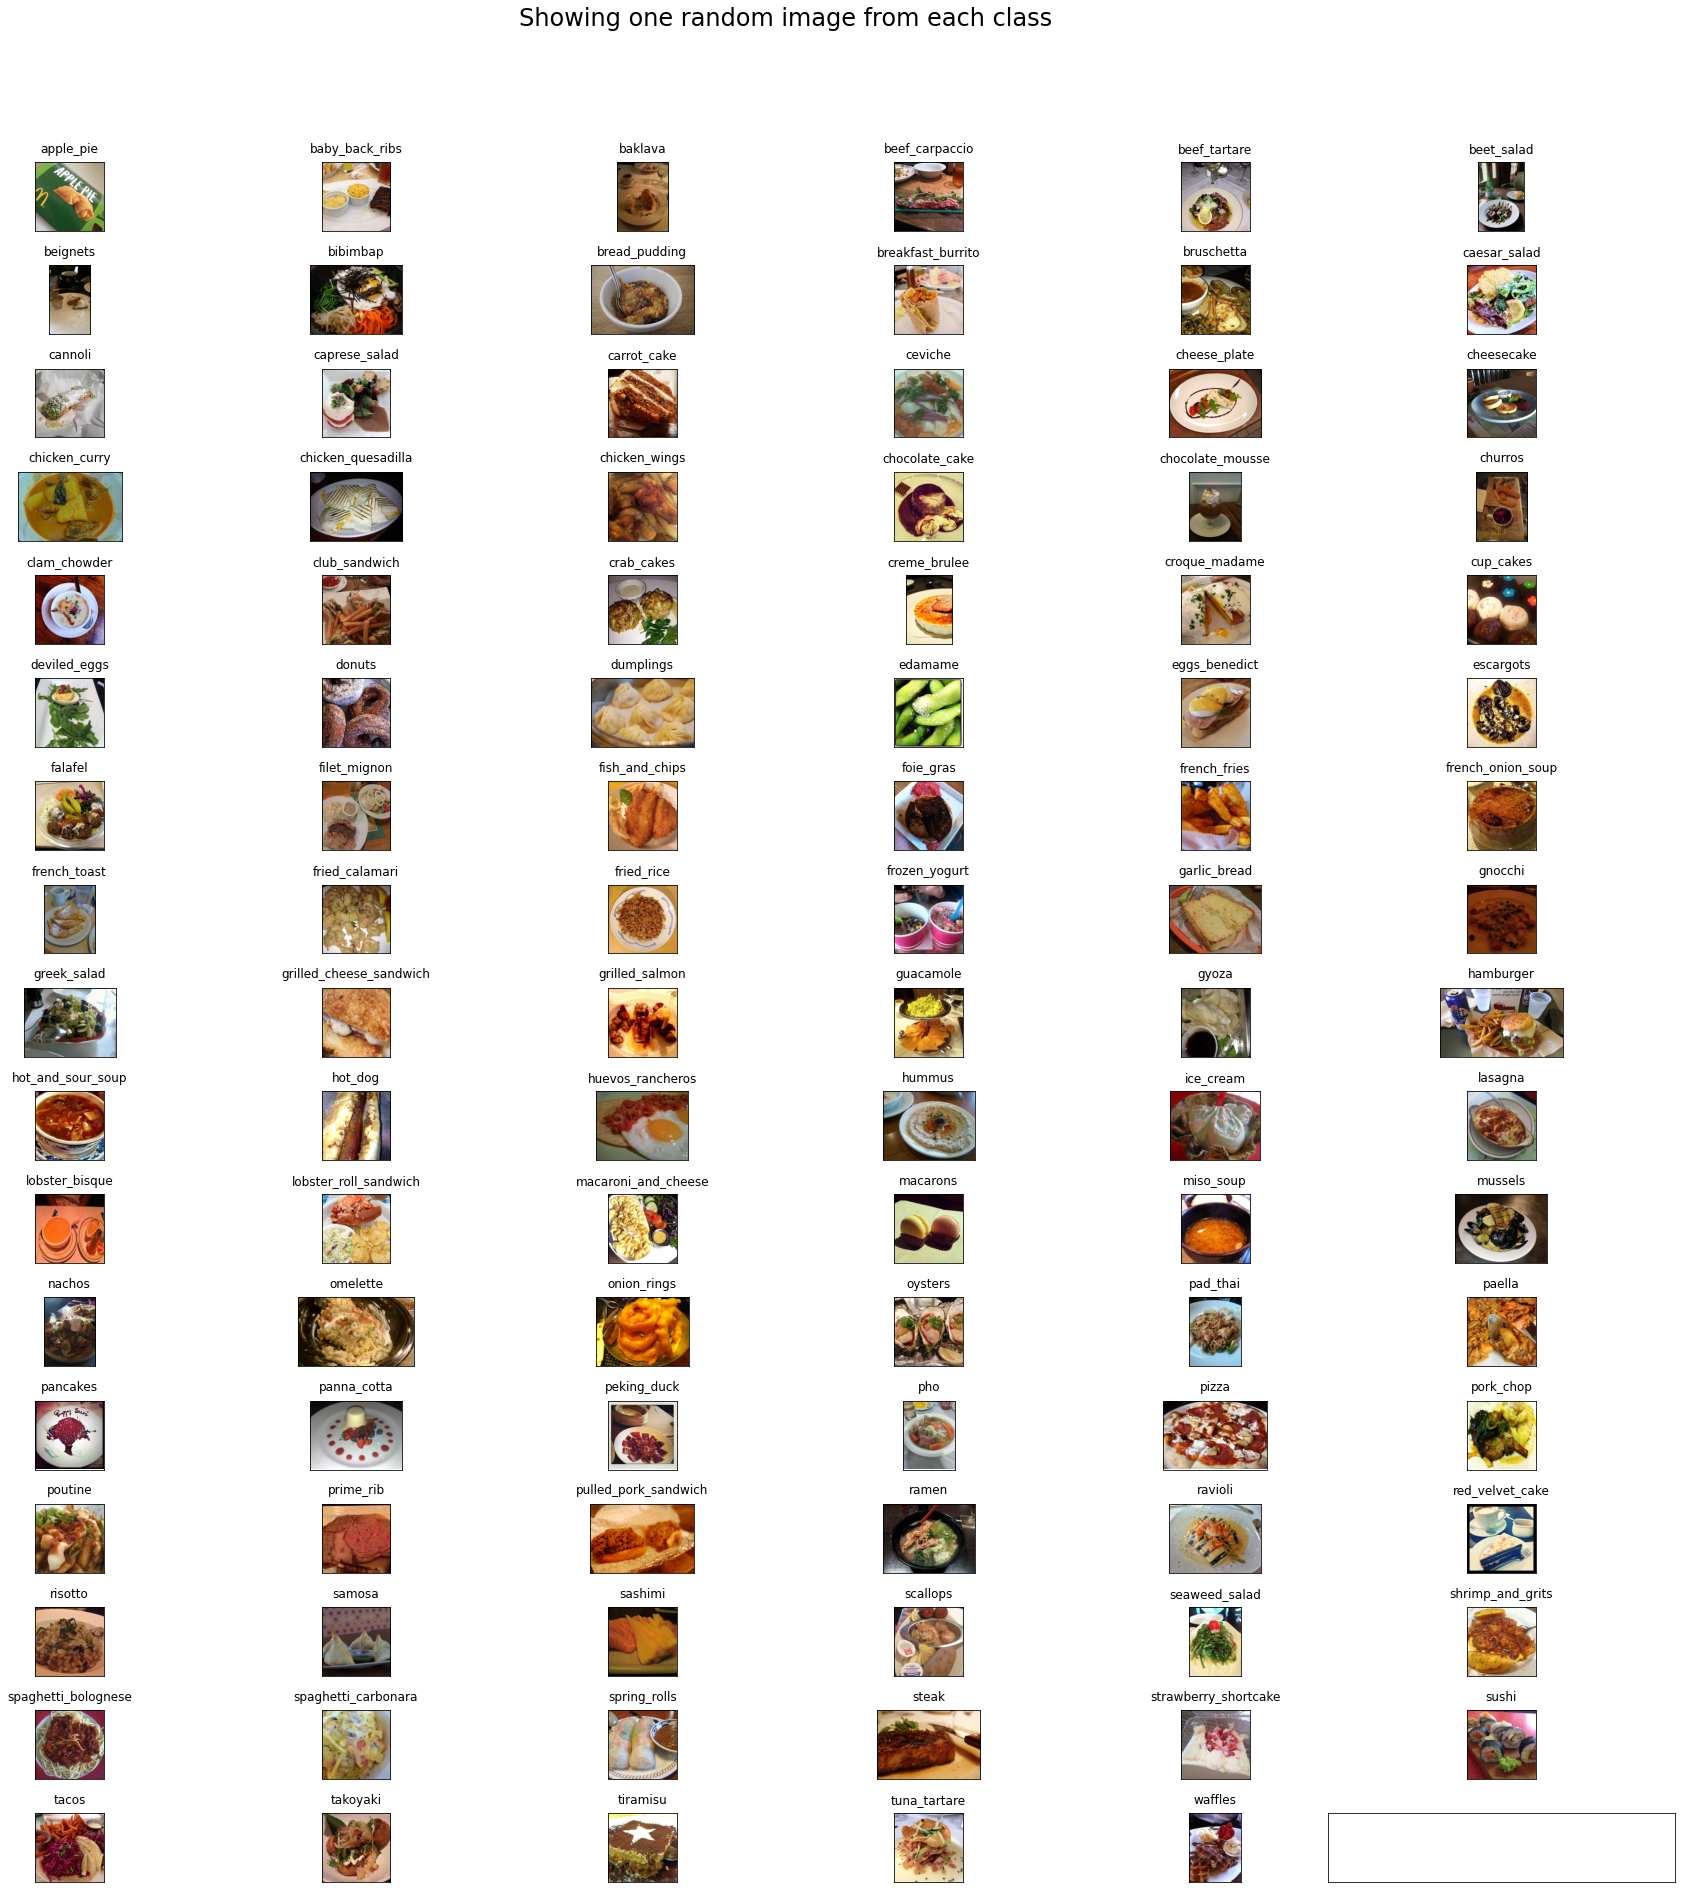

In [11]:
# Visualize the data, showing one image per class from 101 classes
rows = 17
cols = 6
fig, ax = plt.subplots(rows, cols, figsize=(25,25))
fig.suptitle("Showing one random image from each class", y=1.05, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
data_dir = "food-101/images/"
foods_sorted = sorted(os.listdir(data_dir))
food_id = 0
for i in range(rows):
      for j in range(cols):
        try:
            food_selected = foods_sorted[food_id] 
            food_id += 1
        except:
            break
        food_selected_images = os.listdir(os.path.join(data_dir,food_selected)) # returns the list of all files present in each food category
        food_selected_random = np.random.choice(food_selected_images) # picks one food item from the list as choice, takes a list and returns one random item
        img = plt.imread(os.path.join(data_dir,food_selected, food_selected_random))
        ax[i][j].imshow(img)
        ax[i][j].set_title(food_selected, pad = 10)
    
plt.setp(ax, xticks=[],yticks=[])
plt.tight_layout()
# https://matplotlib.org/users/tight_layout_guide.html


# Membagi foto sesuai dengan informasi pada train.txt dan test.txt

In [12]:
# Fungsi untuk membuat folder sesuai dengan train dan test
def prepare_data(filepath, src,dest):
    classes_images = defaultdict(list)
    with open(filepath, 'r') as txt:
        paths = [read.strip() for read in txt.readlines()]
        for p in paths:
            food = p.split('/')
            classes_images[food[0]].append(food[1] + '.jpg')
            
    for food in classes_images.keys():
        print("\nCopying images into ",food)
        if not os.path.exists(os.path.join(dest,food)):
            os.makedirs(os.path.join(dest,food))
        for i in classes_images[food]:
            copy(os.path.join(src,food,i), os.path.join(dest,food,i))
    print("Copying Done!")

In [13]:
# Membuat folder train
print("Creating train data...")
prepare_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')

Creating train data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying im

In [14]:
# Membuat folder test
print("Creating test data...")
prepare_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Creating test data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying ima

In [15]:
# Melihat berapa banyak jumlah file gambar yang berada pada folder train

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [16]:
# Melihat berapa banyak jumlah file gambar yang berada pada folder test
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [17]:
# List of all 101 types of foods(sorted alphabetically)
foods_sorted

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

# Membuat Model dengan Inception Pretrained model menggunakan Food 101 dataset

## Predict Data dengan Distributed Strategy, Mirrored Strategy

In [18]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3', '/job:localhost/replica:0/task:0/device:GPU:4', '/job:localhost/replica:0/task:0/device:GPU:5', '/job:localhost/replica:0/task:0/device:GPU:6', '/job:localhost/replica:0/task:0/device:GPU:7')


In [19]:
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 8


In [20]:
def train_model101(n_classes,num_epochs, nb_train_samples,nb_validation_samples):
    K.clear_session()

    img_width, img_height = 299, 299
    train_data_dir = 'food-101/train'
    validation_data_dir = 'food-101/test'
    batch_size = 16 
    bestmodel_path = 'bestmodel_'+str(n_classes)+'class.hdf5'
    trainedmodel_path = 'trainedmodel_'+str(n_classes)+'class.hdf5'
    history_path = 'history_'+str(n_classes)+'.log'

    train_datagen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True)

    test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

    train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_height, img_width),
        batch_size=batch_size,
        class_mode='categorical')
    
    with strategy.scope():
        inception = InceptionV3(weights='imagenet', include_top=False)
        x = inception.output
        x = GlobalAveragePooling2D()(x)
        x = Dense(128,activation='relu')(x)
        x = Dropout(0.2)(x)
    
        predictions = Dense(n_classes,kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)
    
        model = Model(inputs=inception.input, outputs=predictions)
        model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  
    checkpoint = ModelCheckpoint(filepath=bestmodel_path, verbose=1, save_best_only=True)
    csv_logger = CSVLogger(history_path)
    
    history = model.fit_generator(train_generator,
                                  steps_per_epoch = nb_train_samples // batch_size,
                                  validation_data=validation_generator,
                                  validation_steps=nb_validation_samples // batch_size,
                                  epochs=num_epochs,
                                  verbose=1,
                                  callbacks=[csv_logger, checkpoint])
    
    model.save(trainedmodel_path)
    class_map = train_generator.class_indices
    return history, class_map

In [21]:
def pick_n_random_classes(n):
    random.seed(9000)
    food_list = []
    random_food_indices = random.sample(range(len(foods_sorted)),n) # We are picking n random food classes
    for i in random_food_indices:
        food_list.append(foods_sorted[i])
    food_list.sort()
    print("These are the randomly picked food classes we will be training the model on...\n", food_list)
    return food_list

In [22]:
n = 101
food_list = pick_n_random_classes(101)

These are the randomly picked food classes we will be training the model on...
 ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheese_plate', 'cheesecake', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobste

In [23]:
# Melihat berapa banyak jumlah file gambar yang berada pada folder train

train_files = sum([len(files) for i, j, files in os.walk("food-101/train")])
print("Total number of samples in train folder")
print(train_files)

Total number of samples in train folder
75750


In [24]:
# Melihat berapa banyak jumlah file gambar yang berada pada folder test
test_files = sum([len(files) for i, j, files in os.walk("food-101/test")])
print("Total number of samples in test folder")
print(test_files)

Total number of samples in test folder
25250


In [ ]:
# Train the model with data from 101 classes
n_classes = 101
epochs = 10
nb_train_samples = train_files
nb_validation_samples = test_files

history, class_map_101 = train_model101(n_classes,epochs, nb_train_samples,nb_validation_samples)
print(class_map_101)

In [25]:
%%time
# Loading the best saved model to make predictions

K.clear_session()

with strategy.scope():
    model_best = load_model('bestmodel_101class.hdf5',compile = False)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

## Visualisasi Akurasi dan Loss Setiap Epoch

In [26]:
def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['accuracy']) # change acc to accuracy if testing TF 2.0
    plt.plot(history.history['val_accuracy']) # change val_accuracy if testing TF 2.0
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()


def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

NameError: name 'history' is not defined

In [27]:
def predict_class(model, images, show = True):
  y_pred = []
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    y_pred.append(index)
    food_list.sort()
    pred_value = food_list[index]
    # print(y_pred)
    if show:
        plt.imshow(img[0])                           
        plt.axis('off')
        plt.title(pred_value)
        plt.show()

  return y_pred

In [ ]:
images = []

dir = 'food-101/test'

for i in sorted(os.listdir(dir)):
  for j in sorted(os.listdir(dir + "/" + i)):
      images.append(dir + "/" + i + "/" + j)

y_pred = predict_class(model_best, images, False)

Instructions for updating:
Use `tf.data.Iterator.get_next_as_optional()` instead.


In [ ]:
y_true = []
first = []
dir = 'food-101/test'

for i in sorted(os.listdir(dir)):
  first.append(dir+"/"+i)

for j in first:
  for k in sorted(os.listdir(j)):
      y_true.append(first.index(j))

In [ ]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(64, 60))
sns.heatmap(confusion_mtx, xticklabels=food_list, yticklabels=food_list, annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.savefig('figure8GPU.png')

In [ ]:
# serialize model to JSON
model_json = model_best.to_json()
with open("model101.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model_best.save_weights("model101.h5")
print("Saved model to disk")

# References
* Deep Learning with Python by Francois Cholett - must read really!
* [Building Powerful Image Classification Models](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)
* [How Convolutional Neural Networks See the World](https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html)
* [The Building Blocks of Interpretability](https://distill.pub/2018/building-blocks/)
* [Feature Visualization](https://distill.pub/2017/feature-visualization/)